In [1]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator

class ImprovedSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.005, epochs=50, random_state=7, verbose=False,
                 lambda_scaling='log', patience=5, decay_factor=0.5, min_learning_rate=1e-6,
                 n_control_points=5, smoothing_factor=0.1, spline_type='cubic'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_scaling = lambda_scaling
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type

        if lambda_scaling not in ['log', 'sqrt', 'none']:
            raise ValueError("lambda_scaling must be one of 'log', 'sqrt', or 'none'")
        if spline_type not in ['cubic', 'pchip']:
            raise ValueError("spline_type must be one of 'cubic' or 'pchip'")

        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []
        np.random.seed(random_state)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = np.mean(X[mask_1], axis=0)
        self.m0 = np.mean(X[~mask_1], axis=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1  # Last feature as output
        self.control_x = []
        self.control_y = []
        for m in range(n_features):
            x_min, x_max = X[:, m].min(), X[:, m].max()
            x_range = x_max - x_min
            x_min_ext = x_min - 0.2 * x_range
            x_max_ext = x_max + 0.2 * x_range
            self.control_x.append(np.linspace(x_min_ext, x_max_ext, self.n_control_points))
            self.control_y.append(np.random.uniform(-0.05, 0.05, self.n_control_points))
            if self.n_control_points > 2:
                self.control_y[m][0] = self.control_y[m][1]
                self.control_y[m][-1] = self.control_y[m][-2]
        self.initial_control_x = [cx.copy() for cx in self.control_x]
        self.initial_control_y = [cy.copy() for cy in self.control_y]
        self.control_point_history.append(([cx.copy() for cx in self.control_x],
                                         [cy.copy() for cy in self.control_y]))

    def _fit_spline(self):
        self.splines = [CubicSpline(self.control_x[m], self.control_y[m], bc_type='clamped')
                       if self.spline_type == 'cubic'
                       else PchipInterpolator(self.control_x[m], self.control_y[m])
                       for m in range(len(self.control_x))]

    def _calculate_displacement(self, X):
        f_x = np.sum([self.splines[m](X[:, m]) for m in range(len(self.splines))], axis=0)
        return X[:, -1] - f_x

    def _update_pseudo_labels(self, X, y):
        f_m1 = sum(self.splines[m](self.m1[m]) for m in range(len(self.splines)))
        displacement_m1 = self.m1[-1] - f_m1
        self.class_1_pseudo = 1 if displacement_m1 > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return np.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] < 2:
            raise ValueError("Data must have at least 2 features")

        X = np.asarray(X)
        y = np.asarray(y)

        self.error_history_ = []
        self.learning_rate_history_ = []
        self.control_point_history = []
        self.displacement_history = []
        self.error_index_history = []

        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        best_error = float('inf')
        best_control_x = None
        best_control_y = None
        best_class_1_pseudo = None

        patience_counter = 0
        current_learning_rate = self.initial_learning_rate

        indices_class_0 = np.where(y == 0)[0]
        indices_class_1 = np.where(y == 1)[0]

        for epoch in range(self.epochs):
            pseudo_labels = self._update_pseudo_labels(X, y)
            displacements = self._calculate_displacement(X)
            errors = (displacements * pseudo_labels <= 0)
            error_count = np.sum(errors)

            self.error_history_.append(error_count)
            self.learning_rate_history_.append(current_learning_rate)
            self.displacement_history.append(displacements.copy())
            self.error_index_history.append(np.where(errors)[0].copy())

            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_learning_rate:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_x = [cx.copy() for cx in self.control_x]
                best_control_y = [cy.copy() for cy in self.control_y]
                best_class_1_pseudo = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_learning_rate = max(current_learning_rate * self.decay_factor, self.min_learning_rate)
                    patience_counter = 0
                    if current_learning_rate == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if errors.any():
                error_indices = np.where(errors)[0]
                for idx in error_indices:
                    d = X[idx]
                    margin = max(0.1, min(1.0, 0.2))

                    if y[idx] == 1:
                        opp_indices = indices_class_0
                    else:
                        opp_indices = indices_class_1

                    opp_displacements = displacements[opp_indices]
                    opp_labels = pseudo_labels[opp_indices]
                    correct_opp = opp_indices[opp_displacements * opp_labels > margin]

                    random_avg_opp = None
                    if len(correct_opp) > 0:
                        n_random = max(1, min(len(correct_opp) // 5, 5))
                        random_correct = np.random.choice(correct_opp, size=n_random, replace=False)
                        random_avg_opp = np.mean(X[random_correct], axis=0)

                    for m in range(len(self.splines)):
                        distances = np.abs(self.control_x[m] - d[m])
                        nearest_idx = np.argmin(distances)
                        distance = distances[nearest_idx]

                        if self.lambda_scaling == 'log':
                            lmbda = np.log1p(distance)
                        elif self.lambda_scaling == 'sqrt':
                            lmbda = np.sqrt(distance)
                        else:
                            lmbda = distance

                        if random_avg_opp is not None:
                            delta_x = random_avg_opp[m] - self.control_x[m][nearest_idx]
                            step_x = delta_x * current_learning_rate / (1 + lmbda)
                            other_splines_sum = sum(np.clip(self.splines[k](d[k]), -1e6, 1e6)
                                                for k in range(len(self.splines)) if k != m)
                            if not np.isfinite(other_splines_sum):
                                other_splines_sum = 0  # Fallback to avoid NaN propagation
                            target_y = random_avg_opp[-1] - other_splines_sum
                            delta_y = target_y - self.control_y[m][nearest_idx]
                        else:
                            step_x = 0
                            delta_y = -pseudo_labels[idx] * margin

                        step_y = delta_y * current_learning_rate / (1 + lmbda)

                        # Apply updates with bounds
                        self.control_x[m][nearest_idx] += np.clip(step_x, -1e3, 1e3)
                        self.control_y[m][nearest_idx] += np.clip(step_y, -1e3, 1e3)

                        # Boundary handling
                        if nearest_idx == 0 or nearest_idx == len(self.control_x[m]) - 1:
                            self.control_x[m][nearest_idx] *= 0.9  # Softer dampening
                            self.control_y[m][nearest_idx] *= 0.9
                            if nearest_idx == 0 and self.n_control_points > 2:
                                delta_y = self.control_y[m][1] - self.control_y[m][0]
                                self.control_y[m][0] = self.control_y[m][1] - 0.5 * delta_y
                            elif nearest_idx == len(self.control_x[m]) - 1 and self.n_control_points > 2:
                                delta_y = self.control_y[m][-1] - self.control_y[m][-2]
                                self.control_y[m][-1] = self.control_y[m][-2] + 0.5 * delta_y

                # Sort and enforce minimum spacing
                for m in range(len(self.splines)):
                    sorted_idx = np.argsort(self.control_x[m])
                    self.control_x[m] = self.control_x[m][sorted_idx]
                    self.control_y[m] = self.control_y[m][sorted_idx]
                    # Enforce minimum spacing
                    min_gap = 1e-6
                    for i in range(1, len(self.control_x[m])):
                        if self.control_x[m][i] - self.control_x[m][i-1] < min_gap:
                            self.control_x[m][i] = self.control_x[m][i-1] + min_gap

                self._fit_spline()
                self.control_point_history.append(([cx.copy() for cx in self.control_x],
                                                [cy.copy() for cy in self.control_y]))

        self.control_x = best_control_x
        self.control_y = best_control_y
        self._fit_spline()
        self.class_1_pseudo = best_class_1_pseudo
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X)
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(12, 5)):
        try:
            import matplotlib.pyplot as plt
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
            ax1.plot(self.error_history_, 'b-', label='Errors')
            ax1.set_title('Error Convergence')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Number of Errors')
            ax1.grid(True)
            if hasattr(self, 'best_epoch'):
                ax1.axvline(x=self.best_epoch, color='g', linestyle='--',
                            label=f'Best (Epoch {self.best_epoch})')
            ax2.plot(self.learning_rate_history_, 'r-', label='Learning Rate')
            ax2.set_title('Learning Rate Decay')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Learning Rate')
            ax2.set_yscale('log')
            ax2.grid(True)
            plt.tight_layout()
            fig.legend()
            return fig
        except ImportError:
            print("Install matplotlib with 'pip install matplotlib'!")
            return None

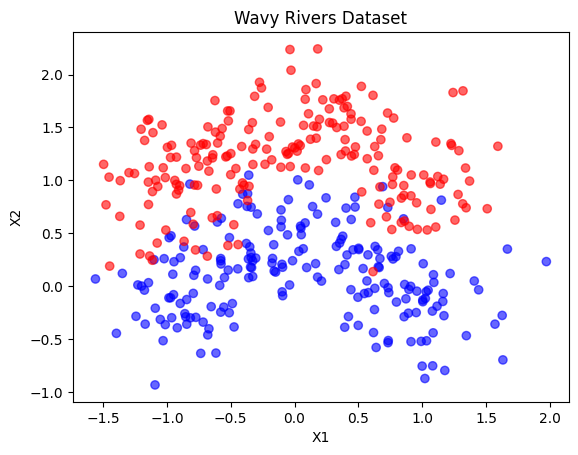

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def make_crescent_waves(n_samples=400, noise=0.3, random_state=42):
    np.random.seed(random_state)
    n = n_samples // 2
    theta = np.random.uniform(0, np.pi, n)

    # Class 0: Lower crescent
    x0 = np.cos(theta) + noise * np.random.randn(n)
    y0 = np.sin(theta) - 0.5 + noise * np.random.randn(n)

    # Class 1: Upper crescent
    x1 = np.cos(theta + np.pi) + noise * np.random.randn(n)
    y1 = -np.sin(theta + np.pi) + 0.5 + noise * np.random.randn(n)

    X = np.vstack((np.column_stack((x0, y0)), np.column_stack((x1, y1))))
    y = np.hstack((np.zeros(n), np.ones(n)))
    return X, y

X, y = make_crescent_waves(n_samples=400)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.6)
plt.title("Wavy Rivers Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [4]:
print(y)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 54)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV 1/5] END epochs=400, lambda_scaling=log, learning_rate=0.005, n_control_points=10, patience=5, smoothing_factor=1e-06, spline_type=cubic;, score=0.891 total time=   0.2s
[CV 4/5] END epochs=400, lambda_scaling=log, learning_rate=0.005, n_control_points=10, patience=5, smoothing_factor=1e-06, spline_type=cubic;, score=0.859 total time=   0.2s
[CV 5/5] END epochs=400, lambda_scaling=log, learning_rate=0.005, n_control_points=10, patience=5, smoothing_factor=1e-06, spline_type=cubic;, score=0.906 total time=   0.2s
[CV 3/5] END epochs=400, lambda_scaling=log, learning_rate=0.005, n_control_points=10, patience=5, smoothing_factor=1e-06, spline_type=cubic;, score=0.875 total time=   0.2s
[CV 3/5] END epochs=400, lambda_scaling=log, learning_rate=0.005, n_control_points=10, patience=5, smoothing_factor=1e-05, spline_type=cubic;, score=0.875 total time=   0.2s
[CV 2/5] END epochs=400, lambda_scaling=log, learning_rate=0.005, 

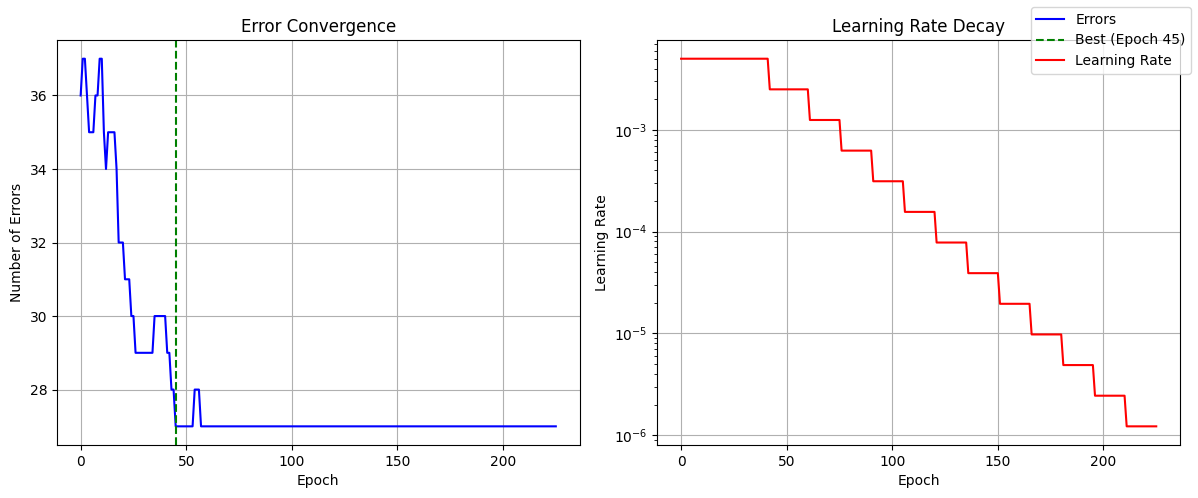

In [6]:
param_grid = {
    'learning_rate': [0.005, 0.01, 0.1],
    'epochs': [400],
    'patience' : [5,10,15],
    'n_control_points': [10, 15, 20, 30],
    'lambda_scaling': ['log', 'sqrt', 'none'],
    'spline_type': ['cubic', 'pchip'],
    'smoothing_factor': [0.000001, 0.00001]
}

# Initialize model with your base settings
smpa = ImprovedSMPA(random_state=9)

# Grid search
grid_search = GridSearchCV(smpa, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose = 3)
grid_search.fit(X_train_minmax, y_train)

# Results
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Test set evaluation
y_pred = grid_search.predict(X_test_minmax)
print("\nGradientSMPA Grid Search Classification Report:")
print(classification_report(y_test, y_pred))

# Plot convergence for best model (after refitting manually if needed)
best_model = grid_search.best_estimator_
fig = best_model.plot_convergence()
plt.show()

In [7]:
test_score = best_model.score(X_test_minmax, y_test)
print("Test score with best model: ", test_score)

Test score with best model:  0.9


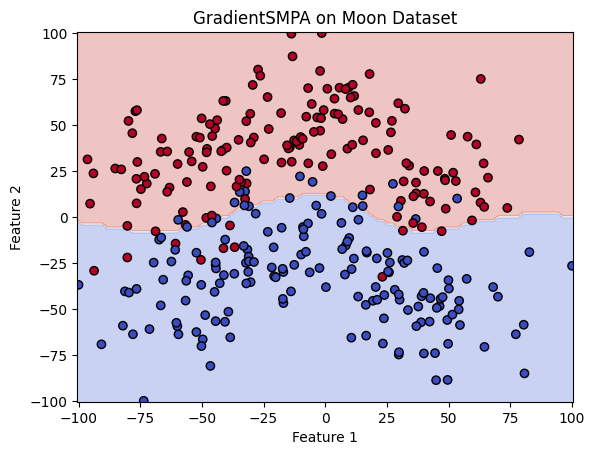

In [8]:
xx, yy = np.meshgrid(np.linspace(X_train_minmax[:,0].min()-0.5, X_train_minmax[:,0].max()+0.5, 100),
                     np.linspace(X_train_minmax[:,1].min()-0.5, X_train_minmax[:,1].max()+0.5, 100))
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_minmax[:,0], X_train_minmax[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("GradientSMPA on Moon Dataset")
plt.show()

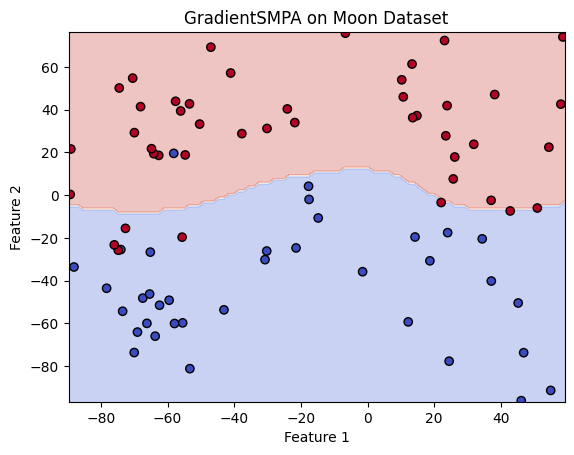

In [9]:
xx, yy = np.meshgrid(np.linspace(X_test_minmax[:,0].min()-0.5, X_test_minmax[:,0].max()+0.5, 100),
                     np.linspace(X_test_minmax[:,1].min()-0.5, X_test_minmax[:,1].max()+0.5, 100))
Z = best_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_minmax[:,0], X_test_minmax[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("GradientSMPA on Moon Dataset")
plt.show()

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # Explicitly set to 'rbf'
}

# Create an instance of SVM
svm = SVC(random_state=42)

# Instantiate the GridSearchCV object:
# - 'svm' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_model_new = grid_search.best_estimator_
test_score = best_model_new.score(X_test, y_test)
print("Test set score with best model: {:.2f}".format(test_score))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.92
Test set score with best model: 0.86


In [12]:
print("\nClassification Report:")
print(classification_report(y_test, best_model_new.predict(X_test_scaled)))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.97      0.92        36
         1.0       0.97      0.89      0.93        44

    accuracy                           0.93        80
   macro avg       0.93      0.93      0.92        80
weighted avg       0.93      0.93      0.93        80



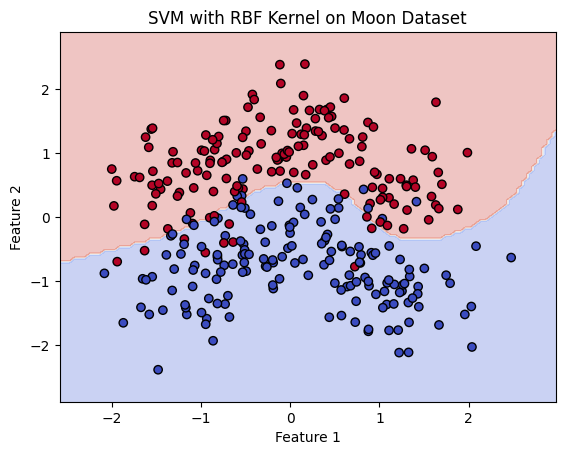

In [13]:
xx, yy = np.meshgrid(np.linspace(X_train_scaled[:,0].min()-0.5, X_train_scaled[:,0].max()+0.5, 100),
                     np.linspace(X_train_scaled[:,1].min()-0.5, X_train_scaled[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_train_scaled[:,0], X_train_scaled[:,1], c=y_train, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()

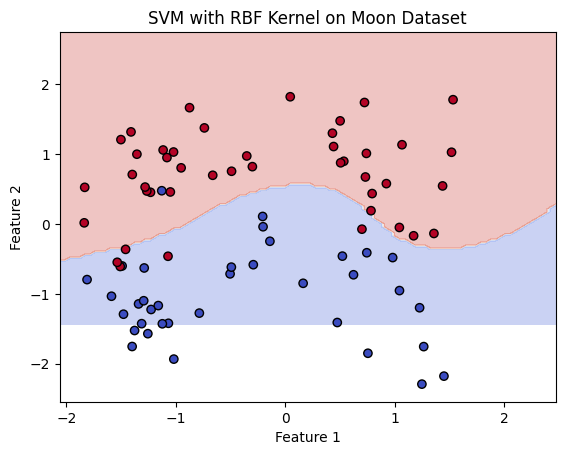

In [14]:
xx, yy = np.meshgrid(np.linspace(X_train[:,0].min()-0.5, X_train[:,0].max()+0.5, 100),
                     np.linspace(X_train[:,1].min()-0.5, X_train[:,1].max()+0.5, 100))
Z = best_model_new.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_test_scaled[:,0], X_test_scaled[:,1], c=y_test, cmap='coolwarm', edgecolors='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("SVM with RBF Kernel on Moon Dataset")
plt.show()